In [1]:
!pip install emoji
!pip install accelerate \
  bitsandbytes \
  transformers==4.36.2 \
  sentencepiece \
  datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 35.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Usi

In [17]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import string
from transformers import BertTokenizer, BertModel
import torch
from collections import Counter
from nltk.tokenize import word_tokenize
import emoji
import numpy as np

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Анализ данных

In [7]:
data = pd.read_csv('train_spam.csv')
data.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3196 entries, 0 to 3195
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  3196 non-null   object
 1   text       3196 non-null   object
dtypes: object(2)
memory usage: 50.1+ KB


In [9]:
data['text_type'].value_counts()

text_type
ham     2255
spam     941
Name: count, dtype: int64

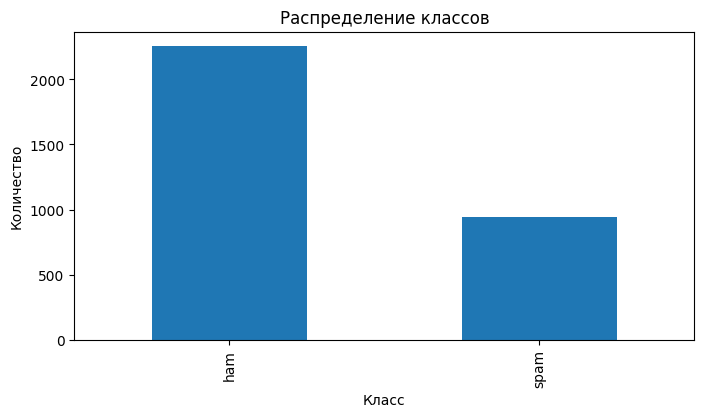

In [10]:
plt.figure(figsize=(8, 4))
data['text_type'].value_counts().plot(kind='bar')
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.show()

<Figure size 1200x600 with 0 Axes>

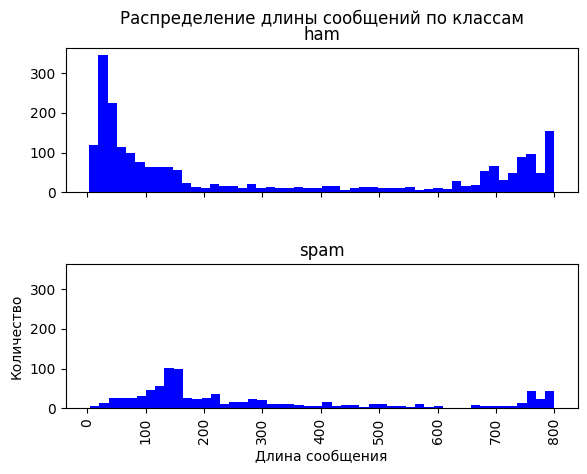

In [11]:
data['message_length'] = data['text'].apply(len)
plt.figure(figsize=(12, 6))
data.hist(column='message_length', by='text_type', bins=50, layout=(2, 1), sharex=True, sharey=True, color='blue')
plt.suptitle('Распределение длины сообщений по классам')
plt.xlabel('Длина сообщения')
plt.ylabel('Количество')
plt.show()

In [12]:
data.head()

,text_type,text,message_length
0,ham,make sure alex knows his birthday is over in f...,86
1,ham,a resume for john lavorato thanks vince i will...,520
2,spam,plzz visit my website moviesgodml to get all m...,126
3,spam,urgent your mobile number has been awarded wit...,139
4,ham,overview of hr associates analyst project per ...,733


# Предобработка данных


In [13]:
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['msg_len'] = data['text'].apply(lambda x: len(x) - x.count(" "))
data['punct%'] = data['text'].apply(lambda x: count_punct(x))

def clean_text(text):
    text = emoji.demojize(text, delimiters=("", " "))
    text = "".join([word.lower() if word not in string.punctuation else ' ' for word in text])
    tokens = re.split('\W+', text)
    text = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords and word.strip()]
    if not text:
        text = ["<empty>"]
    return text

In [14]:
spam_msgs = data[data['text_type'] == "spam"]['text']
tokenizer = nltk.RegexpTokenizer(r'\w+')

def clean_tokenize(text):
    tokens = tokenizer.tokenize(text.lower())
    filter_words = [word for word in tokens if word not in stopwords and len(word) > 1]
    return filter_words

words = []
for msg in spam_msgs:
    words.extend(clean_tokenize(msg))

word_counts = Counter(words)

most_common_words = word_counts.most_common(10)
spam_words_set = set([word for word, count in most_common_words])

def spam_word_percent(text):
    words = word_tokenize(text.lower())
    spam_words_count = sum(1 for word in words if word in spam_words_set)
    total_words_count = len(words)
    if total_words_count > 0:
        return (spam_words_count / total_words_count)
    else:
        return 0.
data['spam_word_percent'] = data['text'].apply(spam_word_percent)

In [15]:
X = data[['text','msg_len', 'punct%', 'spam_word_percent']]
Y = data['text_type']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [25]:
y_train = np.where(Y_train.values == 'spam', 1, 0)
y_test = np.where(Y_test.values == 'spam', 1, 0)

In [77]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', model_max_length = 512 )
model = BertModel.from_pretrained('bert-base-uncased', torch_dtype=torch.float16, load_in_8bit=True, device_map="cuda:0")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [78]:
def bert_vectorize(text):
    cleaned_text = clean_text(text)
    tokens = tokenizer(cleaned_text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**tokens)
    cls_embedding = outputs.last_hidden_state[0,0,:]
    return cls_embedding.numpy()

X_train_bert = [bert_vectorize(text) for text in X_train['text'].values.tolist()[:100]]
X_test_bert = [bert_vectorize(text) for text in X_test['text'].values.tolist()[:100]]

In [79]:
X_train_bert = np.array(X_train_bert)
X_test_bert = np.array(X_test_bert)

In [80]:
feature_train_array = np.array(X_train[['msg_len', 'punct%', 'spam_word_percent']].values[:100])
feature_test_array = np.array(X_test[['msg_len', 'punct%', 'spam_word_percent']].values[:100])

In [81]:
X_train_vect = np.concatenate([X_train_bert, feature_train_array], axis = 1)
X_test_vect = np.concatenate([X_test_bert, feature_test_array], axis = 1)

# Попробуем разные модели

На подбор оптимальных параметров мне, увы 😭😭😭😭😭, не хватило времени………


## RandomForest с перебором параметров

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensamble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from skelarn.model_selection import GridSearchCV

In [ ]:
rf = RandomForestClassifier()
param = {'n_estimators': [100, 200, 300],
         'max_depth': [10, 20, 30]}
grid_search = GridSearchCV(rf, param_grid=param, cv=5, scoring='roc_auc')
grid_search.fit(X_train_vect, y_train)

print("Лучшая модель:", grid_search.best_params_)
roc_auc = roc_auc_score(y_test, grid_search.predict_proba(X_test_vect)[:, 1])
print("ROC-AUC Score:", roc_auc)

## LogisticRegression

In [ ]:
model = LogisticRegression()
model.fit(X_train_vect, y_train)
y_pred = model.predict_proba(X_test_vect)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC Score:", roc_auc)

## GradientBoosting


In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

X_train = np.array(X_train_vect)
X_test = np.array(X_test_vect)
Y_train = np.array(y_train)
Y_test = np.array(y_test)

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='auc')

params = {
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'eta': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='roc_auc', n_jobs=-1, cv=3, verbose=1)
grid_search.fit(X_train, Y_train)

print("Лучшие параметры:", grid_search.best_params_)
best_model = grid_search.best_estimator_

preds = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(Y_test, preds)

print("ROC-AUC Score for XGBoost with best parameters:", roc_auc)


In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

cat_model = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', verbose=0)

param_grid = {
    'iterations': [100, 200],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.3],
    'l2_leaf_reg': [1, 3, 5]
}

grid_search = GridSearchCV(estimator=cat_model, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=2, n_jobs=-1)

grid_search.fit(X_train_vect, y_train, eval_set=(X_test_vect, y_test))

print("Лучшие параметры:", grid_search.best_params_)
best_cat_model = grid_search.best_estimator_

cat_preds = best_cat_model.predict_proba(X_test_bert_vect)[:, 1]
roc_auc_cat = roc_auc_score(Y_test, cat_preds)
print("ROC-AUC Score for optimized CatBoost:", roc_auc_cat)


# Лучшая модель

In [82]:
test = pd.read_csv('test_spam.csv')
test.head()

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


In [83]:
test['spam_word_percent'] = data['text'].apply(spam_word_percent)
test['msg_len'] = test['text'].apply(lambda x: len(x) - x.count(" "))
test['punct%'] = test['text'].apply(lambda x: count_punct(x))
test.head()

,text,spam_word_percent,msg_len,punct%
0,j jim whitehead ejw cse ucsc edu writes j you ...,0.000000,567,0.0
1,original message from bitbitch magnesium net p...,0.030928,479,0.0
2,java for managers vince durasoft who just taug...,0.090909,560,0.0
3,there is a youtuber name saiman says,0.043478,30,0.0
4,underpriced issue with high return on equity t...,0.007874,618,0.0


In [84]:
X_test_fin = [bert_vectorize(text) for text in test['text'].values.tolist()[:100]]
X_test_fin = np.array(X_test_fin)

In [85]:
feature_test_fin = np.array(test[['msg_len', 'punct%', 'spam_word_percent']].values[:100])

In [86]:
X_train_fin = np.concatenate([X_train_vect, X_test_vect])
y_train_fin = np.concatenate([y_train, y_test])[:200]
X_test_fin = np.concatenate([X_test_fin, feature_test_fin], axis=1)

In [87]:
X_train_fin.shape

(200, 771)

In [88]:
y_train_fin.shape

(200,)

In [89]:
X_test_fin.shape

(100, 771)

In [57]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.5 MB/s eta 0:00:00


In [92]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np
model = CatBoostClassifier(iterations=100,
                           learning_rate=0.01,
                           depth=10,
                           eval_metric='AUC',
                           random_seed=42,
                           verbose=200)

model.fit(X_train_fin, y_train_fin)
predictions_proba = model.predict_proba(X_test_fin)


0:	total: 1.85s	remaining: 3m 3s
99:	total: 2m 30s	remaining: 0us


In [93]:
probabilities = predictions_proba[:, 1]

results = pd.DataFrame({
    'text': test['text'][:100],
    'probability_class_1': probabilities
})
results.to_csv('results.csv', index=False)